# Comparing the predictive performance of Deepred-Mt



## Environment

In [1]:
import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt
import sklearn.metrics as metrics

### Deepred-Mt installation

In [2]:
!pip install -U "deepredmt @ git+https://github.com/aedera/deepredmt.git" > /dev/null

  Running command git clone -q https://github.com/aedera/deepredmt.git /tmp/pip-install-ifnj0j3a/deepredmt


## Make predictions

To predict C-to-U editing sites, we will download data that include nucleotide windows extracted from mitochondrial protein-coding genes of diverse plants.

In [3]:
!wget https://raw.githubusercontent.com/aedera/deepredmt/main/data/training-data.tsv.gz

--2021-05-21 16:29:08--  https://raw.githubusercontent.com/aedera/deepredmt/main/data/training-data.tsv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1498835 (1.4M) [application/octet-stream]
Saving to: ‘training-data.tsv.gz.2’

training-data.tsv.g 100%[===================>]   1.43M  --.-KB/s    in 0.08s   

2021-05-21 16:29:08 (18.9 MB/s) - ‘training-data.tsv.gz.2’ saved [1498835/1498835]



As it is explained [here](https://github.com/aedera/deepredmt/blob/main/data/README.md), this data is composed of eleven fields, where nucleotide windows are stored in the fields #4, #5, and #6.

In [4]:
!zcat training-data.tsv.gz | \
  cut -f4,5,6 | \
  tr -d '\t' > wins.tsv

!shuf wins.tsv | head -10 | column -t

AAATCCCTTTTCTTAATACCCETATTCECCETTCATCCGGA
AGAGAAAGTCTTTTTTATTCCTTTGTCTEGAACTTEGTGAA
CAAAGCCCGCTTTCTTCGCTCCGCGAATGAGAGAGAAACTC
TCAAGATCAAATCTGTTTATCAAAGTGCTTCTCEGATTGCT
CATAATTGGGAGAAGCTCATCCGAAACTAGAGCTAGAAACG
CGAGTTATCTACGGACCCTCCCTGCAGTGCGCCCCTCCTTG
ATAGTCAAAATAAGAAGGGACGTGCTATATCCGAAACGTAC
GTATCTACTCGTTACGGAATCGTGGGTGTCAAGGTTTGGAT
TEATTCCTATEGTATATCGTCGTCACGCCCTTAATGATAGG
GAGCCATTGAAGCAGCGCGTCGGGCTAEAATCGGACAATTC


Now, we will use Deepred-Mt to predict which of the central positions of these nucleotide windows are edited.

In [5]:
!deepredmt wins.tsv > deepredmt-pred.tsv

2021-05-21 16:29:09.184406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-21 16:29:12.980906: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-21 16:29:12.982039: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-21 16:29:12.994026: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-21 16:29:12.994074: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2ffe8e9a9e7e): /proc/driver/nvidia/version does not exist
2021-05-21 16:29:12.994629: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-21 16:29:20.760337: I tensorflow/compiler/mlir/mlir_graph_optimizati

## Comparing the predictive performance of Deepred-Mt

Next, we will compare Deepred-Mt predictions with the C-to-U editing sites previously identified for the downloaded sequences, which are stored in the field #9. In addition, we will also include in this comparison the predictive performance of two state-of-the-art methods to predict editing sites:

* [PREPACT](http://www.prepact.de/prepact-main.php)
* [PREP-Mt](http://prep.unl.edu/)

The predictions of both methods are already available in the fields #10 and #11.


In [6]:
!paste <(zcat training-data.tsv.gz | cut -f9,10,11) deepredmt-pred.tsv > predictions.tsv


To measure the predictive performance, we can use precision and recall, which are standard metrics often used in practice. You can find more information regarding these metrics in this [notebook](https://colab.research.google.com/github/aedera/deepredmt/blob/main/notebooks/01_prediction_from_fasta.ipynb).

In [7]:
# Read predictions
preds = np.loadtxt('predictions.tsv')
y_true, y_prepact, y_prepmt, y_deepredmt = preds[:,0], preds[:,1], preds[:,2], preds[:,3]

# evaluate performance
prepact_pre, prepact_rec, _ = metrics.precision_recall_curve(y_true, y_prepact)
prepmt_pre, prepmt_rec, _ = metrics.precision_recall_curve(y_true, y_prepmt)
deepredmt_pre, deepredmt_rec, _ = metrics.precision_recall_curve(y_true, y_deepredmt)

Now, we can compare the precision and recall obtained for each method.

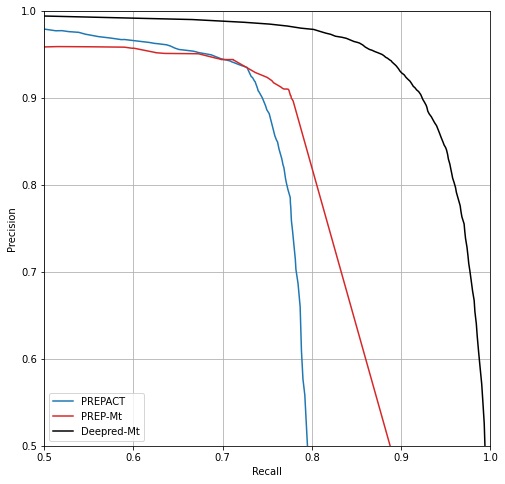

In [8]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 8))

# draw curves
plt.plot(prepact_rec, prepact_pre, c='tab:blue', label='PREPACT')
plt.plot(prepmt_rec, prepmt_pre, c='tab:red', label='PREP-Mt')
plt.plot(deepredmt_rec, deepredmt_pre, c='black', label='Deepred-Mt')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

ax.set_xlim([0.5, 1])
ax.set_ylim([0.5, 1])
plt.grid(True)

plt.show()